In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import nltk
import string
import seaborn
import re
import string as sns  # Tutorial about Python regular expressions: https://pymotw.com/2/re/
import pickle
import os

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from collections import Counter 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter 
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from gensim.models import KeyedVectors
from tqdm import tqdm

In [35]:
lr_ar = pd.read_csv('Reviews.csv', nrows=100000) #100k datapoints
lr_ar.shape

(100000, 10)

In [36]:
def partition(x):
    if x < 3:
        return 0
    return 1

actualScore = lr_ar['Score']
positiveNegative = actualScore.map(partition) 
lr_ar['Score'] = positiveNegative
print("Number of data points in our data", lr_ar.shape)

Number of data points in our data (100000, 10)


In [37]:
lr_ar.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [38]:
#Sorting data according to ProductId in ascending order
sorted_data=lr_ar.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [39]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(88463, 10)

In [40]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(lr_ar['Id'].size*1.0)*100

88.46300000000001

In [41]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [42]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(88461, 10)


1    75313
0    13148
Name: Score, dtype: int64

#  Featurization

In [43]:
x = lr_ar['Text'].values
y= lr_ar['Score'].values

##  BAG OF WORDS

In [44]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33) 
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) 


print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) 
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

(44890,) (44890,)
(22110,) (22110,)
(33000,) (33000,)
After vectorizations
(44890, 39523) (44890,)
(22110, 39523) (22110,)
(33000, 39523) (33000,)


<h2> Applying Logistic Regression With Penalty L1 </h2>

In [45]:
clf = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='warn', max_iter=100, multi_class='warn', verbose=0, warm_start=False, n_jobs=None)
clf.fit(X_train_bow, y_train)
pred = clf.predict(X_train_bow) 
print(pred)

[0 1 0 ... 1 1 1]


In [115]:
clf.predict_proba(X_train_bow)[0:30]

array([[6.40994980e-01, 3.59005020e-01],
       [4.52769765e-03, 9.95472302e-01],
       [1.62567286e-03, 9.98374327e-01],
       [2.98494365e-02, 9.70150564e-01],
       [1.05407150e-01, 8.94592850e-01],
       [3.80489584e-03, 9.96195104e-01],
       [7.16841584e-03, 9.92831584e-01],
       [1.30694256e-02, 9.86930574e-01],
       [9.77331398e-02, 9.02266860e-01],
       [5.96675798e-03, 9.94033242e-01],
       [7.69239131e-03, 9.92307609e-01],
       [7.48877734e-02, 9.25112227e-01],
       [5.02061645e-04, 9.99497938e-01],
       [8.40646763e-04, 9.99159353e-01],
       [1.47000745e-01, 8.52999255e-01],
       [7.61492402e-04, 9.99238508e-01],
       [2.10103219e-01, 7.89896781e-01],
       [4.26181863e-01, 5.73818137e-01],
       [3.64022338e-04, 9.99635978e-01],
       [4.46271294e-02, 9.55372871e-01],
       [2.30826438e-02, 9.76917356e-01],
       [6.61895455e-04, 9.99338105e-01],
       [2.01482332e-05, 9.99979852e-01],
       [1.68234659e-03, 9.98317653e-01],
       [7.837901

In [116]:
clf.score(X_train_bow, y_train)

0.9567386945867676

In [117]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='warn', max_iter=100, multi_class='warn', verbose=0, warm_start=False, n_jobs=None)
clf.fit(X_train_bow, y_train)
clf.predict(X_train_bow)

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [118]:
clf.predict_proba(X_train_bow) 

array([[6.59831286e-01, 3.40168714e-01],
       [4.23046008e-03, 9.95769540e-01],
       [7.83324698e-04, 9.99216675e-01],
       ...,
       [5.57093208e-02, 9.44290679e-01],
       [2.10498260e-01, 7.89501740e-01],
       [1.34301058e-06, 9.99998657e-01]])

In [119]:
clf.score(X_train_bow, y_train)

0.972287814658053

In [120]:
roc_auc_score(y_train, pred)

0.8848384547633548

<h2> Sparcity </h2>

In [121]:
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/4%20Amazon%20Food%20Reviews%20-%20Logistic%20Regression.ipynb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train_bow,y_train)
y_pred = clf.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 87.985%
F1-Score on test set: 0.929
Non Zero weights: 9214


In [122]:
clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_train_bow,y_train)
y_pred = clf.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.400%
F1-Score on test set: 0.932
Non Zero weights: 8730


In [123]:
clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_train_bow,y_train)
y_pred = clf.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 89.345%
F1-Score on test set: 0.938
Non Zero weights: 7730


In [124]:
clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_train_bow,y_train)
y_pred = clf.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.703%
F1-Score on test set: 0.946
Non Zero weights: 4137


In [125]:
clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_train_bow,y_train)
y_pred = clf.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 89.888%
F1-Score on test set: 0.943
Non Zero weights: 797


In [126]:
clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_train_bow,y_train)
y_pred = clf.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 86.488%
F1-Score on test set: 0.926
Non Zero weights: 128


<h2> Hyper Parameter Tuning (Best Alpha) </h2>

In [127]:
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/4%20Amazon%20Food%20Reviews%20-%20Logistic%20Regression.ipynb
from sklearn.model_selection import GridSearchCV
clf = LogisticRegression()
param_grid = {'C':[10**-5, 10**-4, 10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4], 'penalty':['l1','l2']}
gsv = GridSearchCV(clf,param_grid,verbose=1)
gsv.fit(X_train_bow,y_train)
print("Best HyperParameter: ",gsv.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  4.9min finished


Best HyperParameter:  {'C': 1, 'penalty': 'l1'}


<h2> Feature Engineering </h2>

In [128]:
from sklearn import preprocessing
bi_gram = CountVectorizer(ngram_range=(1,2)) 
X_train_fe = bi_gram.fit_transform(X_train)
#Normalize Data
X_train_fe = preprocessing.normalize(X_train_fe)
print("Train Data Size: ",X_train_fe.shape)
X_test_fe = bi_gram.transform(X_test)
#Normalize Data
X_test_fe = preprocessing.normalize(X_test_fe)
print("Test Data Size: ",X_test_fe.shape)

Train Data Size:  (44890, 720274)
Test Data Size:  (33000, 720274)


<h2> Feature Importance </h2>

In [129]:
clf = LogisticRegression(C= 1, penalty= 'l2')
clf.fit(X_train_bow,y_train)
y_pred = clf.predict(X_test_bow)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\t\tTop 10 Features Importance\t\t\t\t\t\t")
    print("________________________________________________________________________________________________")
   
    print("\tPositive Class\t\t\t\t\tNegative Class")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(vectorizer,clf)


Non Zero weights: 39582
				Top 10 Features Importance						
________________________________________________________________________________________________
	Positive Class					Negative Class
________________________________________________________________________________________________
	-2.9394	worst          				1.9811	proper         
	-2.1388	disappointing  				1.8455	beat           
	-2.0755	terrible       				1.8145	awesome        
	-2.0194	tasteless      				1.7914	overall        
	-1.9972	awful          				1.6973	perfect        
	-1.7610	shame          				1.6626	exceptional    
	-1.7374	dissappointed  				1.6570	excellent      
	-1.7024	disgusting     				1.6408	grilled        
	-1.6950	glorified      				1.6191	enjoys         
	-1.6947	inedible       				1.5568	delicious      


<h2> Performance Of Model </h2>

<h2> Train Data </h2>

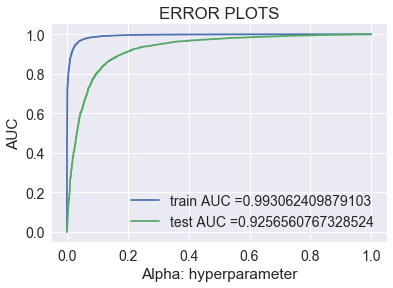

In [130]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
c = [10**-5, 10**-4, 10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4]
for i in c:
    lr = LogisticRegression()
    lr.fit(X_train_bow, y_train)
   
    y_train_pred =  lr.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  lr.predict_proba(X_cv_bow)[:,1]
    train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train_bow)[:,1])
    cv_fpr, cv_tpr, thresholds = roc_curve(y_cv, lr.predict_proba(X_cv_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(cv_fpr, cv_tpr, label="test AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
    

<h2> Confusion Matrix For Train Data </h2>

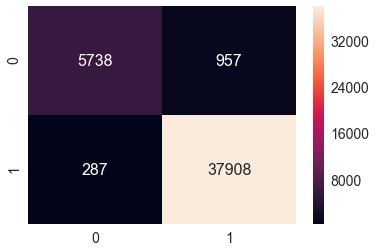

In [131]:
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Re20KNNviews%20-%%20.ipynb
lr = LogisticRegression(C= 1, penalty= 'l2')
lr.fit(X_train_bow,y_train)
y_pred = lr.predict(X_train_bow)
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Cross-Validation Data </h2>

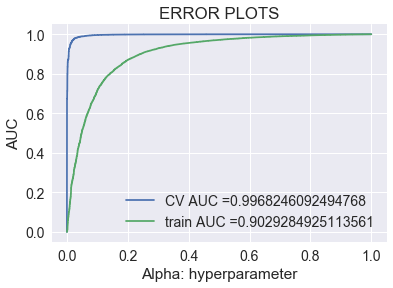

In [132]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

c = [10**-5, 10**-4, 10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4]
for i in c:
    
    lr = LogisticRegression()
    lr.fit(X_cv_bow, y_cv)
   
    y_cv_pred =  lr.predict_proba(X_cv_bow)[:,1]
    y_train_pred =  lr.predict_proba(X_train_bow)[:,1]
    cv_fpr, cv_tpr, thresholds = roc_curve(y_cv, lr.predict_proba(X_cv_bow)[:,1])
    train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train_bow)[:,1])

plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
    

<h2> Test Data </h2>

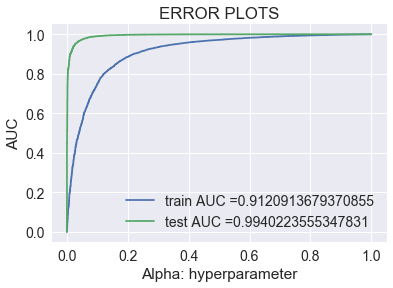

In [133]:
from sklearn.metrics import roc_curve, auc
C = 1
lr = LogisticRegression(C=1)
lr.fit(X_test_bow, y_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

<h2> Confusion Matrix For Test Data </h2>

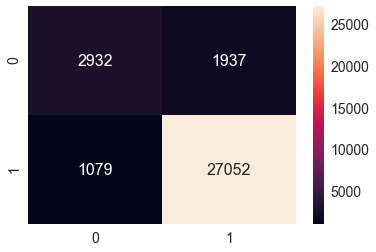

In [134]:
clf = LogisticRegression(C= 1, penalty= 'l2')
clf.fit(X_train_bow,y_train)
y_pred = clf.predict(X_test_bow)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> TF_IDF </h2>

In [135]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
vectorizer_1 =  TfidfVectorizer()
vectorizer_1.fit(X_train) 

X_train_tfidf = vectorizer_1.transform(X_train)
X_cv_tfidf = vectorizer_1.transform(X_cv)
X_test_tfidf = vectorizer_1.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(44890, 39582) (44890,)
(22110, 39582) (22110,)
(33000, 39582) (33000,)


<h2> Applying Logictic Regrassion </h2>

In [136]:
clf = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='warn', max_iter=100, multi_class='warn', verbose=0, warm_start=False, n_jobs=None)
clf.fit(X_train_tfidf, y_train)

clf.predict(X_train_tfidf)

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [137]:
clf.predict_proba(X_train_tfidf)[0:30] 

array([[7.65326911e-01, 2.34673089e-01],
       [1.11246455e-02, 9.88875354e-01],
       [8.54612404e-03, 9.91453876e-01],
       [1.99112968e-02, 9.80088703e-01],
       [2.51063140e-01, 7.48936860e-01],
       [1.80498726e-02, 9.81950127e-01],
       [2.35830725e-02, 9.76416927e-01],
       [5.18680786e-02, 9.48131921e-01],
       [3.46903062e-01, 6.53096938e-01],
       [2.90437443e-03, 9.97095626e-01],
       [8.44304691e-02, 9.15569531e-01],
       [1.12474404e-02, 9.88752560e-01],
       [7.99802828e-02, 9.20019717e-01],
       [2.26230216e-03, 9.97737698e-01],
       [2.62137711e-01, 7.37862289e-01],
       [3.59286489e-02, 9.64071351e-01],
       [1.77920541e-01, 8.22079459e-01],
       [1.57907309e-01, 8.42092691e-01],
       [7.11915995e-04, 9.99288084e-01],
       [7.42055179e-02, 9.25794482e-01],
       [6.87373599e-02, 9.31262640e-01],
       [1.08667613e-02, 9.89133239e-01],
       [3.56824532e-02, 9.64317547e-01],
       [3.50485400e-02, 9.64951460e-01],
       [4.789191

In [138]:
clf.score(X_train_tfidf, y_train)

0.9172421474715973

<h2> logistic Regression With Penalty L2 </h2>

In [139]:
clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='warn', max_iter=100, multi_class='warn', verbose=0, warm_start=False, n_jobs=None)
clf.fit(X_train_tfidf, y_train)

pred_1 =clf.predict(X_train_tfidf)
print(pred_1)

[0 1 1 ... 1 1 1]


In [140]:
clf.predict_proba(X_train_tfidf)[0:30]

array([[0.6877699 , 0.3122301 ],
       [0.01438667, 0.98561333],
       [0.01842824, 0.98157176],
       [0.05494111, 0.94505889],
       [0.19558741, 0.80441259],
       [0.03226599, 0.96773401],
       [0.07130263, 0.92869737],
       [0.05446138, 0.94553862],
       [0.36205897, 0.63794103],
       [0.01477888, 0.98522112],
       [0.0851219 , 0.9148781 ],
       [0.04043031, 0.95956969],
       [0.08500832, 0.91499168],
       [0.00755852, 0.99244148],
       [0.19190067, 0.80809933],
       [0.03895224, 0.96104776],
       [0.19360146, 0.80639854],
       [0.20860907, 0.79139093],
       [0.00327993, 0.99672007],
       [0.06985235, 0.93014765],
       [0.06124915, 0.93875085],
       [0.02116671, 0.97883329],
       [0.04140732, 0.95859268],
       [0.06026361, 0.93973639],
       [0.07352145, 0.92647855],
       [0.13414522, 0.86585478],
       [0.07834679, 0.92165321],
       [0.03558229, 0.96441771],
       [0.05025324, 0.94974676],
       [0.06330388, 0.93669612]])

In [141]:
clf.score(X_train_tfidf, y_train)

0.9206504789485409

In [142]:
roc_auc_score(y_train, pred_1)

0.7648381145415398

<h2> Pertubation Testing </h2>

In [143]:
clf = LogisticRegression(C= 500, penalty= 'l2')
clf.fit(X_train_tfidf,y_train)
y_pred = clf.predict(X_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 89.418%
Non Zero weights: 39582


In [144]:
from scipy.sparse import find
w1 = find(clf.coef_[0])[2]
print(w1[:50])

[-5.56518587e+00  1.88791212e+00  1.45271350e-02  3.58090100e-02
  3.36197197e+00  1.67136145e+00  1.74199067e-03  1.21844436e-02
  1.21844436e-02  1.21844436e-02  1.21844436e-02  1.21844436e-02
  1.21844436e-02  1.21844436e-02  1.21844436e-02  1.21844436e-02
 -1.30766675e+00  1.74199067e-03 -5.49532645e+00  1.15557330e-01
  4.69993809e-03 -8.25140601e-01  1.08729576e+00  1.86756670e-02
 -9.21750792e-02  8.23616205e-02 -3.38491285e-01  1.89349801e-01
  2.93103574e-01  7.52060203e-02 -7.41888890e-01 -7.46453566e-01
 -1.73937015e+00 -7.26376349e+00  1.41465243e-01 -2.43883343e+00
  1.24120098e-01 -3.63282978e+00  3.38286650e-02  3.38286650e-02
  5.32445225e-01  7.18670871e-02  9.62541871e+00 -6.30479588e+00
 -1.16639682e+00  5.62707754e-02  7.55521579e+00 -1.42087579e-01
  6.51703800e-01  5.32445225e-01]


In [145]:
print(w1[w1<=0.0001])

[-5.56518587 -1.30766675 -5.49532645 ... -7.84977029 -5.59301332
 -2.09422974]


In [146]:
X_train_t = X_train_tfidf
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
a,b,c = find(X_train_t)
X_train_t[a,b] = epsilon + X_train_t[a,b]

In [147]:
clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_t,y_train)
y_pred = clf.predict(X_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.188%
Non Zero weights: 39582


In [148]:
w2 = find(clf.coef_[0])[2]
print(w2[:50])

[-1.75959701  0.79612658  0.05534679  0.03465148  0.30006631  0.12698354
  0.00668748  0.04688253  0.04693233  0.04692227  0.04701625  0.04690845
  0.04703094  0.04700129  0.04690732  0.04697246 -0.20236034  0.00668737
 -0.6208144   0.0491084   0.01200828 -1.16039724  0.16895551  0.04119727
 -0.01960526  0.0117718  -0.34588668  0.46300779  0.10307462  0.02165235
  0.49234547 -0.37966384 -0.65697333 -0.83118086  0.03609066 -0.43268765
  0.03560522 -0.4029252   0.03516928  0.03518494  0.13881581  0.03276439
  1.08087285 -1.13508776 -0.23652949  0.02563885  1.53853365 -0.19331786
  0.10695838  0.13887091]


In [149]:
print(w2.size)

39582


In [150]:
weights_diff = (abs(w1 - w2)/w1) * 100

In [151]:
print(weights_diff[np.where(weights_diff > 30)].size)

25887


<h2>*In Pertubation Test Print The Features Names </h2>

In [152]:
def show_most_informative_features(vectorizer_1, clf, n=10):
    feature_names = vectorizer_1.get_feature_names()
    coefs_with_fns = sorted(zip(weights_diff, feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])

    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
show_most_informative_features(vectorizer_1,clf)

	-84245.9074	tastier        				16701.9424	canal          
	-65219.4536	hand           				16093.6232	motion         
	-15329.5349	chagrin        				15894.0342	scent          
	-8674.3890	previous       				14922.2999	smallest       
	-7732.5868	velveeta       				13713.4746	senna          
	-5535.0308	vitamins       				11611.6722	ten            
	-4420.4878	parrot         				9944.0815	overdone       
	-4413.5960	cornbread      				7201.9157	gyokuro        
	-4184.2367	witnessed      				6748.2777	paying         
	-4066.1364	absolutley     				4692.0844	such           


<h2> Sparsity </h2>

In [153]:
clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train_tfidf,y_train)
y_pred = clf.predict(X_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.321%
F1-Score on test set: 0.931
Non Zero weights: 9162


In [154]:
clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_train_tfidf,y_train)
y_pred = clf.predict(X_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.876%
F1-Score on test set: 0.935
Non Zero weights: 8424


In [155]:
clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_train_tfidf,y_train)
y_pred = clf.predict(X_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 87.255%
F1-Score on test set: 0.930
Non Zero weights: 123


<h2> Hyper Parameter Tuning </h2>

In [156]:
clf = LogisticRegression()
param_grid = {'C':[10**-5, 10**-4, 10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4], 'penalty':['l1','l2']}
gsv = GridSearchCV(clf,param_grid,verbose=1)
gsv.fit(X_train_tfidf,y_train)
print("Best HyperParameter: ",gsv.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  1.0min finished


Best HyperParameter:  {'C': 1, 'penalty': 'l1'}


<h2> Feature Engineering </h2>

In [157]:
bi_gram = TfidfVectorizer(ngram_range=(1,2)) 
X_train_fe = bi_gram.fit_transform(X_train)

X_train_fe = preprocessing.normalize(X_train_fe)
print("Train Data Size: ",X_train_fe.shape)
X_test_fe = bi_gram.transform(X_test)

X_test_fe = preprocessing.normalize(X_test_fe)
print("Test Data Size: ",X_test_fe.shape)

Train Data Size:  (44890, 720274)
Test Data Size:  (33000, 720274)


<h2> Feature Importance </h2>

In [158]:
 clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_tfidf,y_train)
y_pred = clf.predict(X_test_tfidf)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

def show_most_informative_features(vectorizer_1, clf, n=10):
    feature_names = vectorizer_1.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\t\tTop 10 Features Importance\t\t\t\t\t\t")
    print("________________________________________________________________________________________________")
    print("\tPositive Class\t\t\t\t\tNegative Class")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(vectorizer_1,clf)


Non Zero weights: 39582
				Top 10 Features Importance						
________________________________________________________________________________________________
	Positive Class					Negative Class
________________________________________________________________________________________________
	-12.3951	worst          				14.1329	great          
	-10.0449	awful          				11.1629	perfect        
	-9.3033	terrible       				11.0302	delicious      
	-9.2614	disappointing  				10.5960	best           
	-7.8102	disappointed   				9.3615	excellent      
	-7.5213	disappointment 				9.3043	nice           
	-7.4263	waste          				9.1959	good           
	-7.2482	horrible       				9.0190	wonderful      
	-7.0242	tasteless      				8.5102	amazing        
	-6.9390	disgusting     				8.4844	awesome        


<h2> Performance Of Model </h2>

<h2> Train Data </h2>

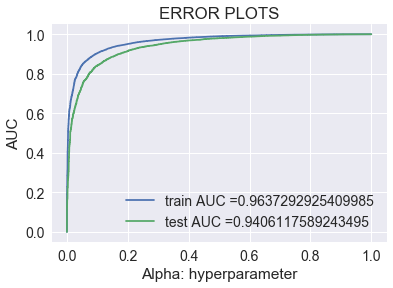

In [159]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
c = [10**-5, 10**-4, 10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4]
for i in c:
    lr = LogisticRegression()
    lr.fit(X_train_tfidf, y_train)
   
    y_train_pred =  lr.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  lr.predict_proba(X_cv_tfidf)[:,1]
    train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train_tfidf)[:,1])
    cv_fpr, cv_tpr, thresholds = roc_curve(y_cv, lr.predict_proba(X_cv_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(cv_fpr, cv_tpr, label="test AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
    

<h2> Confusion Matrix For Train Data </h2>

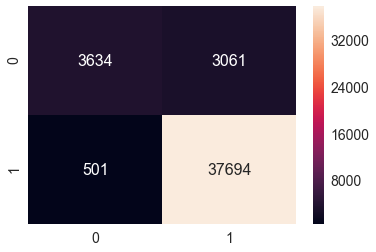

In [160]:
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Re20KNNviews%20-%%20.ipynb

lr = LogisticRegression(C= 1, penalty= 'l2')
lr.fit(X_train_tfidf,y_train)
y_pred = lr.predict(X_train_tfidf)
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Cross-Validation Data </h2>

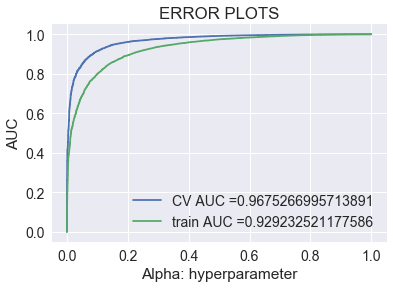

In [161]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

c = [10**-5, 10**-4, 10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4]
for i in c:
    
    lr = LogisticRegression()
    lr.fit(X_cv_tfidf, y_cv)
   
    y_cv_pred =  lr.predict_proba(X_cv_tfidf)[:,1]
    y_train_pred =  lr.predict_proba(X_train_tfidf)[:,1]
    cv_fpr, cv_tpr, thresholds = roc_curve(y_cv, lr.predict_proba(X_cv_tfidf)[:,1])
    train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train_tfidf)[:,1])

plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
    

<h2> Test Data </h2>

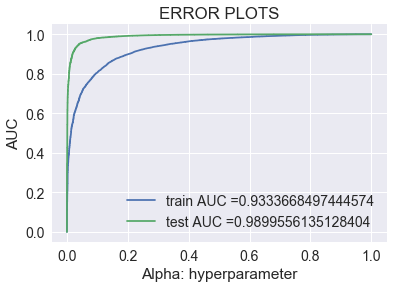

In [162]:
C = 10
lr = LogisticRegression(C=10)
lr.fit(X_test_tfidf, y_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

<h2> Confusion Matrix For Test Data </h2>

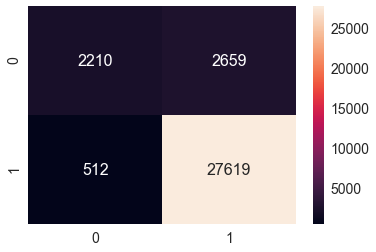

In [163]:
clf = LogisticRegression(C= 1, penalty= 'l2')
clf.fit(X_train_tfidf,y_train)
y_pred = clf.predict(X_test_tfidf)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Word2Vec

In [46]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')


def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/|]',r' ',cleaned)
    return cleaned

print(stop)
print('******************************************')
print(sno.stem('tasty'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'its', 'd', 'y', 'whom', 'while', "shouldn't", "doesn't", 'his', 'isn', 'or', 'i', 'all', 'ourselves', 'we', "that'll", 'above', 'had', 'has', 'yourself', 'ours', "you're", 'does', 'than', 'your', 'after', 'didn', "hadn't", "won't", 's', 'who', 'weren', "couldn't", 'won', 'm', 'how', 'why', 'only', 'me', 'doing', 'because', 'of', "hasn't", "aren't", 'having', 'same', 'couldn', 'further', 'more', 'until', 'they', 'ma', 'our', 'then', "it's", "you've", 'wouldn', 'hadn', 'a', 'on', 'each', 'himself', 'about', 'but', 'out', 'and', 'again', 'once', 'from', 't', 'by', 'my', 'them', 'that', 'is', "shan't", 'was', 'during', 'against', 've', "isn't", 'do', 'into', "she's", "wouldn't", 'these', 'those', 'where', 'no', 'at', 'before', 'any', 'an', "you'd", "haven't", 'over', 'shan', 'hers', 'what', 'been', 'needn', 'herself', 'up', 'are', 'h

In [47]:
i=0
str1=''
final_string=[]
all_positive_words=[]
all_negative_words=[]
s=''
for sent in lr_ar['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (lr_ar['Score'].values)[i] == 'positive':
                        all_positive_words.append(s)
                    if (lr_ar['Score'].values)[i] == 'negative':
                        all_negative_words.append(s)
                    else:
                        continue
                else:
                    continue
    str1 = b" ".join(filtered_sentence)
   # print("***********************************************************************888")
    final_string.append(str1) 
    i+=1

In [48]:
lr_ar['CleanedText']=final_string
import gensim
from gensim.models import word2vec
from gensim.models import keyedvectors
import pickle
#import gensim


i=0
list_of_sent=[]
for sent in lr_ar['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence) 

In [49]:
print(lr_ar['Text'].values[0])
print("***********************************************************************************")
print(list_of_sent[0])


I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
***********************************************************************************
['i', 'have', 'bought', 'several', 'of', 'the', 'vitality', 'canned', 'dog', 'food', 'products', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality', 'the', 'product', 'looks', 'more', 'like', 'a', 'stew', 'than', 'a', 'processed', 'meat', 'and', 'it', 'smells', 'better', 'my', 'labrador', 'is', 'finicky', 'and', 'she', 'appreciates', 'this', 'product', 'better', 'than', 'most']


In [50]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [51]:
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [52]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  25792
sample words  ['It', 'was', 'bad', 'before', 'we', 'open', 'them.', 'I', 'saw', 'them', 'when', 'got.', 'did', 'open.', 'had', 'some', 'spot', 'green', 'color.', 'not', 'know', 'what', 'it', 'was.', 'very', 'upset.', 'Do', 'buy', 'this', 'product.', 'placed', 'the', 'order', 'on', 'tuesday,', 'received', 'saturday', 'with', 'cheapest', 'shipping;', 'super', 'faster.', 'himalayan', 'salt', 'comes', 'in', 'a', 'sealed', 'ziploc', 'bag']


In [53]:
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|████████████████████████████████████████████████████████████████████████████| 44890/44890 [09:25<00:00, 79.43it/s]


(44890, 50)
[-1.32207866 -1.04842886  0.64064857 -0.6280736   1.04336646 -0.00922216
 -0.22173816  0.02742867  0.67114201  0.42777424 -0.42771868  2.25438424
 -0.37666007  0.8190864  -0.00805358 -0.70246006 -0.45183454 -0.76101701
  0.10914156  0.24638367  0.42318085  0.71429604  0.57623587 -0.42930146
 -1.04356092 -0.4826405   0.19930768 -0.09112886  0.37575087 -0.81127529
  0.2355651  -0.43527824  0.0105704  -0.99719149  0.73866351  1.38672636
 -0.33246536  0.62379534 -0.05171633 -0.01408278  0.92707349  0.1765605
 -0.49875856 -0.82269328  0.62149322 -0.02000601 -0.50321443 -0.68259518
  0.25562387  0.1630869 ]


In [54]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [55]:
# average Word2Vec
# compute average word2vec for each review.i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|████████████████████████████████████████████████████████████████████████████| 22110/22110 [04:17<00:00, 85.76it/s]


(22110, 50)
[-7.56630281e-01 -1.92316175e-04  8.09186575e-01  3.34420459e-01
  5.33577071e-01 -6.17481679e-01  3.70707988e-01 -5.32819531e-01
  3.74631361e-01  1.06155191e+00 -1.88203322e-02  1.27262438e+00
 -5.12589458e-01  8.06501874e-01 -1.97442300e-01 -4.38824482e-01
  3.64666998e-03 -4.91539681e-01 -3.19004697e-02 -5.24503014e-02
  1.07515739e-01  7.26048004e-01  7.77407996e-01 -2.80754895e-01
 -8.41673829e-01 -2.12872653e-01  1.34885249e-01 -3.94692199e-01
  9.42511541e-01 -3.66057699e-01  9.41113783e-03 -1.26406877e+00
  2.05534485e-01 -6.08266403e-01  6.00560932e-01  1.11699247e-01
  1.49277286e-01  2.47411836e-01 -6.22235906e-02  1.97117162e-02
  2.09708598e-01 -4.12820609e-01 -4.83980998e-01 -4.72135152e-01
  7.73818265e-02  5.49668069e-01 -4.90998309e-01 -9.13875721e-01
 -5.85470274e-02  3.19515030e-01]


In [56]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [57]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|████████████████████████████████████████████████████████████████████████████| 33000/33000 [06:35<00:00, 83.37it/s]


(33000, 50)
[-0.51059914 -0.37174595  0.81321106 -0.54551895  0.10084489 -0.06353395
  0.03433469 -0.19089737  0.59275537  0.33613082  0.15631533  1.39129289
  0.18752261  0.21157296 -0.11073466 -0.13360631 -0.47795352 -0.34653222
  0.43943535  0.04579974  0.8592431   0.46804279  0.95979614  0.46197947
 -0.45197898 -0.54565966  0.20984642 -0.08207642  0.02428278  0.08067978
 -0.46096137 -0.60966313  0.82873439 -0.79157455  0.44895283  1.42612153
  0.6058865  -0.00953081  0.2791993  -0.24331216  0.3146742  -0.51012369
 -0.24938384 -0.53815669 -0.53337538 -0.45265483  0.25339597 -0.41216763
 -0.30203587  0.2808947 ]


<h2> Applying Logistic Regression With Penalty L1 </h2>

In [176]:
clf = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='warn', max_iter=100, multi_class='warn', verbose=0, warm_start=False, n_jobs=None)
clf.fit(sent_vectors_train, y_train)

pred_2 = clf.predict(sent_vectors_train)
print(pred_2)

[0 1 1 ... 1 1 1]


In [177]:
clf.predict_proba(sent_vectors_train)[0:30] 

array([[0.72108157, 0.27891843],
       [0.04177261, 0.95822739],
       [0.0122383 , 0.9877617 ],
       [0.07150844, 0.92849156],
       [0.08802139, 0.91197861],
       [0.0767147 , 0.9232853 ],
       [0.07399883, 0.92600117],
       [0.03214447, 0.96785553],
       [0.42417185, 0.57582815],
       [0.00402065, 0.99597935],
       [0.23251496, 0.76748504],
       [0.07153272, 0.92846728],
       [0.18809077, 0.81190923],
       [0.01645058, 0.98354942],
       [0.45035593, 0.54964407],
       [0.0388972 , 0.9611028 ],
       [0.21168242, 0.78831758],
       [0.22503337, 0.77496663],
       [0.0078925 , 0.9921075 ],
       [0.13285135, 0.86714865],
       [0.10323637, 0.89676363],
       [0.1107263 , 0.8892737 ],
       [0.13564538, 0.86435462],
       [0.22133945, 0.77866055],
       [0.1318511 , 0.8681489 ],
       [0.06846783, 0.93153217],
       [0.18715475, 0.81284525],
       [0.04494692, 0.95505308],
       [0.10468751, 0.89531249],
       [0.22260861, 0.77739139]])

In [178]:
clf.score(sent_vectors_train, y_train)

0.8609935397638673

In [179]:
roc_auc_score(y_train, pred_2)

0.5958188303193559

<h2> Logistic Regression With Penalty L2 </h2>

In [180]:
clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='warn', max_iter=100, multi_class='warn', verbose=0, warm_start=False, n_jobs=None)
clf.fit(sent_vectors_train, y_train)

clf.predict(sent_vectors_train)

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [181]:
clf.predict_proba(sent_vectors_train)[0:30] 

array([[0.71956928, 0.28043072],
       [0.04234963, 0.95765037],
       [0.01218672, 0.98781328],
       [0.070901  , 0.929099  ],
       [0.08765945, 0.91234055],
       [0.07769962, 0.92230038],
       [0.0743332 , 0.9256668 ],
       [0.03230246, 0.96769754],
       [0.42575228, 0.57424772],
       [0.00400604, 0.99599396],
       [0.23654641, 0.76345359],
       [0.07117395, 0.92882605],
       [0.18679258, 0.81320742],
       [0.01692482, 0.98307518],
       [0.44865031, 0.55134969],
       [0.03842239, 0.96157761],
       [0.21070314, 0.78929686],
       [0.22724777, 0.77275223],
       [0.00809379, 0.99190621],
       [0.13400564, 0.86599436],
       [0.10586246, 0.89413754],
       [0.11305521, 0.88694479],
       [0.13320597, 0.86679403],
       [0.21956734, 0.78043266],
       [0.13226025, 0.86773975],
       [0.0691974 , 0.9308026 ],
       [0.18539426, 0.81460574],
       [0.04485799, 0.95514201],
       [0.1043887 , 0.8956113 ],
       [0.22372031, 0.77627969]])

In [182]:
clf.score(sent_vectors_train, y_train)

0.8609267097349076

<h2> Hyper Parameter Tuning </h2>

In [183]:
clf = LogisticRegression()
param_grid = {'C':[10**-5, 10**-4, 10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4], 'penalty':['l1','l2']}
gsv = GridSearchCV(clf,param_grid,verbose=1)
gsv.fit(sent_vectors_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  4.2min finished


Best HyperParameter:  {'C': 100, 'penalty': 'l1'}


<h2> Performance OF Model </h2>

<h2> Train Data </h2>

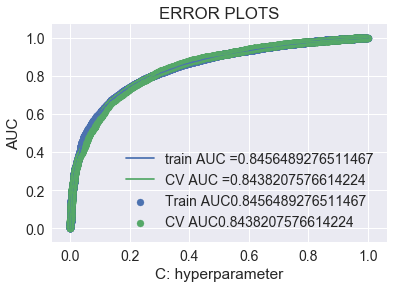

In [184]:
train_auc = []
cv_auc = []

c = [10**-5, 10**-4, 10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4]
for i in c:
    lr = LogisticRegression()
    lr.fit(sent_vectors_train, y_train)
   
    y_train_pred =  lr.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred =  lr.predict_proba(sent_vectors_cv)[:,1]
    train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(sent_vectors_train)[:,1])
    cv_fpr, cv_tpr, thresholds = roc_curve(y_cv, lr.predict_proba(sent_vectors_cv)[:,1])


plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(train_fpr, train_tpr, label='Train AUC'+str(auc(train_fpr, train_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))    
plt.scatter(cv_fpr, cv_tpr, label='CV AUC'+str(auc(cv_fpr, cv_tpr)))    
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
print("="*100)

<h2> Confusion Matrix For Train Data </h2>

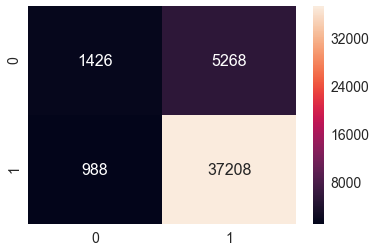

In [60]:
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Re20KNNviews%20-%%20.ipynb
import seaborn as sns
lr = LogisticRegression(C= 100, penalty= 'l2')
lr.fit(sent_vectors_train,y_train)
y_pred = lr.predict(sent_vectors_train)
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Cross-Validation Data </h2>

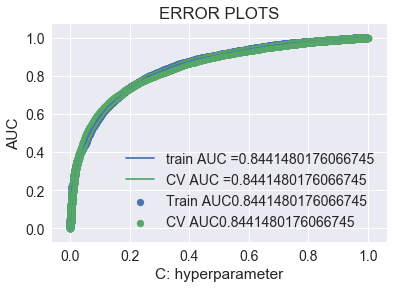

In [186]:
train_auc = []
cv_auc = []

c = [10**-5, 10**-4, 10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4]
for i in c:
    lr = LogisticRegression()
    lr.fit(sent_vectors_cv, y_cv)
   
    y_train_pred =  lr.predict_proba(sent_vectors_cv)[:,1]
    y_cv_pred =  lr.predict_proba(sent_vectors_train)[:,1]
    cv_fpr, cv_tpr, thresholds = roc_curve(y_cv, lr.predict_proba(sent_vectors_cv)[:,1])
    train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(sent_vectors_train)[:,1])


plt.plot(cv_fpr, cv_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(cv_fpr, cv_tpr, label='Train AUC'+str(auc(train_fpr, train_tpr)))
plt.plot(train_fpr, train_tpr, label="CV AUC ="+str(auc(train_fpr, train_tpr)))    
plt.scatter(train_fpr, train_tpr, label='CV AUC'+str(auc(train_fpr, train_tpr)))    
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
print("="*100)

<h2> Test Data </h2>

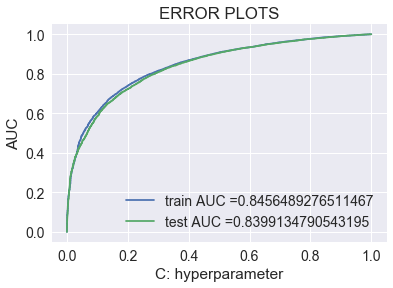

In [187]:
lr = LogisticRegression()
lr.fit(sent_vectors_train, y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

<h2> Confusion Matrix  For Test Data </h2>

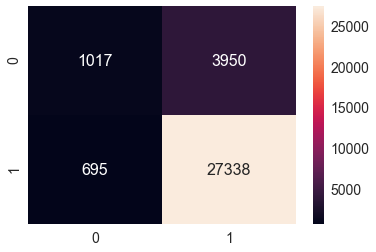

In [61]:
clf = LogisticRegression(C= 100, penalty= 'l2')
clf.fit(sent_vectors_train,y_train)
y_pred = clf.predict(sent_vectors_test)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

### AvgW2V Words 

<h2> Train Data </h2>

In [62]:
from tqdm import tqdm 
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(lr_ar['CleanedText'].values)

dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


tfidf_feat = model.get_feature_names()
tfidf_sent_vectors_train = [];  
row=0;
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))  
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
    
tfidf_sent_vectors_train = np.array(sent_vectors_train)
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

100%|██████████████████████████████████████████████████████████████████████████| 44890/44890 [2:45:09<00:00,  4.53it/s]


(44890, 50)
[-1.32207866 -1.04842886  0.64064857 -0.6280736   1.04336646 -0.00922216
 -0.22173816  0.02742867  0.67114201  0.42777424 -0.42771868  2.25438424
 -0.37666007  0.8190864  -0.00805358 -0.70246006 -0.45183454 -0.76101701
  0.10914156  0.24638367  0.42318085  0.71429604  0.57623587 -0.42930146
 -1.04356092 -0.4826405   0.19930768 -0.09112886  0.37575087 -0.81127529
  0.2355651  -0.43527824  0.0105704  -0.99719149  0.73866351  1.38672636
 -0.33246536  0.62379534 -0.05171633 -0.01408278  0.92707349  0.1765605
 -0.49875856 -0.82269328  0.62149322 -0.02000601 -0.50321443 -0.68259518
  0.25562387  0.1630869 ]


<h2> Cross-Validation Data </h2>

In [63]:
 
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(lr_ar['CleanedText'].values)

dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


tfidf_feat = model.get_feature_names()
tfidf_sent_vectors_cv = [];
row=0;
for sent in tqdm(list_of_sentance_cv):
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))  
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum 
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
tfidf_sent_vectors_cv = np.array(sent_vectors_cv)
print(tfidf_sent_vectors_cv.shape)
print(tfidf_sent_vectors_cv[0])   

100%|████████████████████████████████████████████████████████████████████████████| 22110/22110 [28:10<00:00, 13.08it/s]


(22110, 50)
[-7.56630281e-01 -1.92316175e-04  8.09186575e-01  3.34420459e-01
  5.33577071e-01 -6.17481679e-01  3.70707988e-01 -5.32819531e-01
  3.74631361e-01  1.06155191e+00 -1.88203322e-02  1.27262438e+00
 -5.12589458e-01  8.06501874e-01 -1.97442300e-01 -4.38824482e-01
  3.64666998e-03 -4.91539681e-01 -3.19004697e-02 -5.24503014e-02
  1.07515739e-01  7.26048004e-01  7.77407996e-01 -2.80754895e-01
 -8.41673829e-01 -2.12872653e-01  1.34885249e-01 -3.94692199e-01
  9.42511541e-01 -3.66057699e-01  9.41113783e-03 -1.26406877e+00
  2.05534485e-01 -6.08266403e-01  6.00560932e-01  1.11699247e-01
  1.49277286e-01  2.47411836e-01 -6.22235906e-02  1.97117162e-02
  2.09708598e-01 -4.12820609e-01 -4.83980998e-01 -4.72135152e-01
  7.73818265e-02  5.49668069e-01 -4.90998309e-01 -9.13875721e-01
 -5.85470274e-02  3.19515030e-01]


<h2> Test Data </h2>

In [64]:
 
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(lr_ar['CleanedText'].values)

dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


tfidf_feat = model.get_feature_names()
tfidf_sent_vectors_test = [];
row=0;
for sent in tqdm(list_of_sentance_test):
    
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))  
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

tfidf_sent_vectors_test = np.array(sent_vectors_test)
print(tfidf_sent_vectors_test.shape)
print(tfidf_sent_vectors_test[0])

100%|████████████████████████████████████████████████████████████████████████████| 33000/33000 [47:36<00:00, 11.55it/s]


(33000, 50)
[-0.51059914 -0.37174595  0.81321106 -0.54551895  0.10084489 -0.06353395
  0.03433469 -0.19089737  0.59275537  0.33613082  0.15631533  1.39129289
  0.18752261  0.21157296 -0.11073466 -0.13360631 -0.47795352 -0.34653222
  0.43943535  0.04579974  0.8592431   0.46804279  0.95979614  0.46197947
 -0.45197898 -0.54565966  0.20984642 -0.08207642  0.02428278  0.08067978
 -0.46096137 -0.60966313  0.82873439 -0.79157455  0.44895283  1.42612153
  0.6058865  -0.00953081  0.2791993  -0.24331216  0.3146742  -0.51012369
 -0.24938384 -0.53815669 -0.53337538 -0.45265483  0.25339597 -0.41216763
 -0.30203587  0.2808947 ]


<h2> Applying Logistic Regression With Penalty L1 </h2>

In [192]:
clf = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='warn', max_iter=100, multi_class='warn', verbose=0, warm_start=False, n_jobs=None)
clf.fit(tfidf_sent_vectors_train, y_train)

pred_3 = clf.predict(tfidf_sent_vectors_train)
print(pred_3)

[0 1 1 ... 1 1 1]


In [193]:
clf.predict_proba(tfidf_sent_vectors_train)[0:30]

array([[0.72110331, 0.27889669],
       [0.04174794, 0.95825206],
       [0.01223597, 0.98776403],
       [0.07154936, 0.92845064],
       [0.08798552, 0.91201448],
       [0.07668369, 0.92331631],
       [0.0739944 , 0.9260056 ],
       [0.03213904, 0.96786096],
       [0.4242008 , 0.5757992 ],
       [0.00401675, 0.99598325],
       [0.23257221, 0.76742779],
       [0.07157533, 0.92842467],
       [0.18816906, 0.81183094],
       [0.01644311, 0.98355689],
       [0.45047594, 0.54952406],
       [0.03890366, 0.96109634],
       [0.2116456 , 0.7883544 ],
       [0.22490503, 0.77509497],
       [0.00788825, 0.99211175],
       [0.13277741, 0.86722259],
       [0.1031887 , 0.8968113 ],
       [0.11069597, 0.88930403],
       [0.13572718, 0.86427282],
       [0.22137083, 0.77862917],
       [0.13184937, 0.86815063],
       [0.06850126, 0.93149874],
       [0.18719371, 0.81280629],
       [0.04494739, 0.95505261],
       [0.10469675, 0.89530325],
       [0.22258726, 0.77741274]])

In [194]:
clf.score(tfidf_sent_vectors_train, y_train)

0.8609935397638673

In [195]:
roc_auc_score(y_train, pred_3)

0.5958188303193559

<h2> Logistic Regression With Penalty L2 </h2>

In [196]:
clf = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='warn', max_iter=100, multi_class='warn', verbose=0, warm_start=False, n_jobs=None)
clf.fit(tfidf_sent_vectors_train, y_train)

clf.predict(tfidf_sent_vectors_train)

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [197]:
clf.score(tfidf_sent_vectors_train, y_train)

0.8609935397638673

<h2> Hyper Parameter Tuning </h2>

In [198]:
clf = LogisticRegression()
param_grid = {'C':[10**-5, 10**-4, 10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4], 'penalty':['l1','l2']}
gsv = GridSearchCV(clf,param_grid,verbose=1)
gsv.fit(tfidf_sent_vectors_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  4.5min finished


Best HyperParameter:  {'C': 100, 'penalty': 'l1'}


<h2> Performance Of Model </h2>

<h2> Train Data </h2>

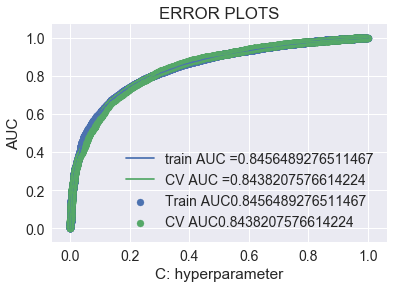

In [199]:
train_auc = []
cv_auc = []

c = [10**-5, 10**-4, 10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4]
for i in c:
    lr = LogisticRegression()
    lr.fit(tfidf_sent_vectors_train, y_train)
   
    y_train_pred =  lr.predict_proba(tfidf_sent_vectors_train)[:,1]
    y_cv_pred =  lr.predict_proba(tfidf_sent_vectors_cv)[:,1]
    train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(tfidf_sent_vectors_train)[:,1])
    cv_fpr, cv_tpr, thresholds = roc_curve(y_cv, lr.predict_proba(tfidf_sent_vectors_cv)[:,1])


plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(train_fpr, train_tpr, label='Train AUC'+str(auc(train_fpr, train_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))    
plt.scatter(cv_fpr, cv_tpr, label='CV AUC'+str(auc(cv_fpr, cv_tpr)))    
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
print("="*100)

<h2> Confusion Matrix For Train Data </h2>

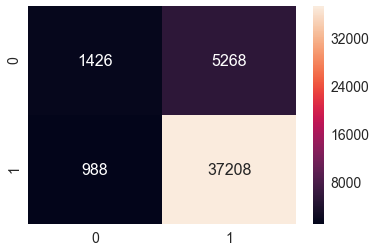

In [65]:
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Re20KNNviews%20-%%20.ipynb
import seaborn as sns
lr = LogisticRegression(C= 100, penalty= 'l2')
lr.fit(tfidf_sent_vectors_train,y_train)
y_pred = lr.predict(tfidf_sent_vectors_train)
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Cross-Validation For Data </h2>

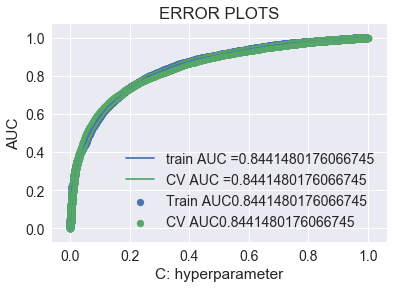

In [201]:
train_auc = []
cv_auc = []

c = [10**-5, 10**-4, 10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4]
for i in c:
    lr = LogisticRegression()
    lr.fit(sent_vectors_cv, y_cv)
   
    y_train_pred =  lr.predict_proba(tfidf_sent_vectors_cv)[:,1]
    y_cv_pred =  lr.predict_proba(tfidf_sent_vectors_train)[:,1]
    cv_fpr, cv_tpr, thresholds = roc_curve(y_cv, lr.predict_proba(tfidf_sent_vectors_cv)[:,1])
    train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(tfidf_sent_vectors_train)[:,1])


plt.plot(cv_fpr, cv_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(cv_fpr, cv_tpr, label='Train AUC'+str(auc(train_fpr, train_tpr)))
plt.plot(train_fpr, train_tpr, label="CV AUC ="+str(auc(train_fpr, train_tpr)))    
plt.scatter(train_fpr, train_tpr, label='CV AUC'+str(auc(train_fpr, train_tpr)))    
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
print("="*100)

<h2> Test Data </h2>

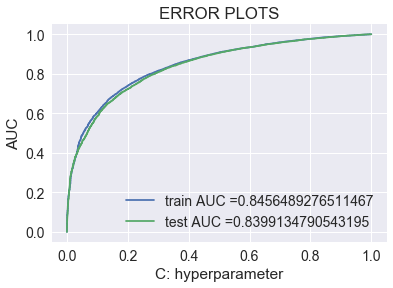

In [202]:
lr = LogisticRegression()
lr.fit(tfidf_sent_vectors_train, y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)



<h2>  Confusion Matrix For Test Data </h2>

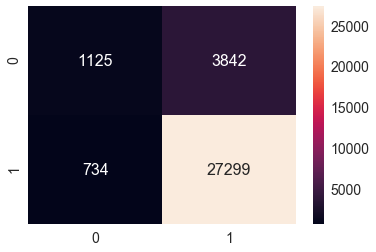

In [66]:
lr = LogisticRegression(C= 100, penalty= 'l2')
lr.fit(tfidf_sent_vectors_test,y_test)
y_pred = lr.predict(tfidf_sent_vectors_test)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Conclusion Table </h2>

In [67]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Set", "Vectorizer", "Model 1", "Hyper Parameter(C)", "Train_AUC", "Test_AUC", "ROC_AUC"]

x.add_row(["Set:-1", "BOW", "Logistic_Regression ", 1, 0.99, 0.99, 0.88])
x.add_row(["Set:-2", "TFIDF", "Logistic_Regression", 1, 0.96, 0.99, 0.76])
x.add_row(["Set:-5", "W2V", "Logistic_Regression", 100, 84.15, 0.84, 0.59])
x.add_row(["Set:-6", "TFIDFW2V", "Logistic_Regression", 100, 0.84, 0.83, 0.59])

print(x)

+--------+------------+----------------------+--------------------+-----------+----------+---------+
|  Set   | Vectorizer |       Model 1        | Hyper Parameter(C) | Train_AUC | Test_AUC | ROC_AUC |
+--------+------------+----------------------+--------------------+-----------+----------+---------+
| Set:-1 |    BOW     | Logistic_Regression  |         1          |    0.99   |   0.99   |   0.88  |
| Set:-2 |   TFIDF    | Logistic_Regression  |         1          |    0.96   |   0.99   |   0.76  |
| Set:-5 |    W2V     | Logistic_Regression  |        100         |   84.15   |   0.84   |   0.59  |
| Set:-6 |  TFIDFW2V  | Logistic_Regression  |        100         |    0.84   |   0.83   |   0.59  |
+--------+------------+----------------------+--------------------+-----------+----------+---------+


<h2> Conclusion </h2>

1. I loaded a amazon fine  food reviews and after that i change score in 0 and 1 where 1 represent positive reviews and  0 represent negative reviews.
2. Then i split whole datapoints into 3parts Train Data , TestData And Cross-validation data.
3. Then i used this splited datapoint for featurization BOW, TF_IDF, W2Vec , AvgW2Vec featurization .
4. Then i used only Train data to avoid dataleakage. and i applied logistic Regression with L1 and L2 in train data 
6. Then i did Pertubation Testing(where we add extra random values in weight and then applied logistic regression on create weught and added values weight after that we calculate :-{w1-w2/w2}*2 the values) and sparsity using logistic regression,
6. Then i find Hyper Parameter Tuning where i found best Hyper Parameter tuning, best Accurancy through GridSerch cross-validation in logistic regression.
7. Then i find feature Importance in logistic Regression where i found top 10 positive and nagative features names in it.
8. Then i ploted Performance of model in train data and test and cross-validation data using logistic regression.
9. Then i caculate confusion matrix where i try to find how many data points are actually positive and negative and how many are predicated datapoint in it.
10. Then  i created Conclusion table using pretty table for 4 featurization where i show the values of best hyper parameter, train_AUC, Test_AUC values in table for all 4 featurization.

 <h2>========================================================================== </h2>